# Praca Domowa 6 - Piotr Sieńko

## Przygotowanie danych

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('clustering_R3.csv')

print(data.shape)
data.head()

(1000, 3)


,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814


Widać, że dane przyjmują wartości z różnych przedziałów, więc trzeba je ustandaryzować.

In [2]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
data =  pd.DataFrame(scaler.fit_transform(data), columns=['x1', 'x2', 'x3'])
data.head()



,x1,x2,x3
0,-0.762807,1.024554,-0.909772
1,-0.819582,1.125110,-0.566853
2,-0.733687,1.029615,-1.004782
3,-0.777429,1.236698,-0.995176
4,-0.781982,1.203537,-0.396348


## 1. Metoda Aglomeracyjna

Aby użyć metody aglomeracyjnej, musimy znaleźć optymalną liczbę klastrów. Do tego celu zastosowałem współczynnik Silhouette oraz Indeks Calińskiego - Harabasza.

### Wybór K

In [3]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

# Miara Silhouette + Caliński-Harabasz

def agg_scores(X, K):
    s_scores = [] 
    c_scores = []
    for k in range(2, K +1):
        model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)
        # Silhouette
        silhouette = silhouette_score(X, labels)
        s_scores.append(silhouette)
        # Caliński-Harabasz
        calinski = calinski_harabasz_score(X, labels)
        c_scores.append(calinski)
        
        
    return s_scores, c_scores 



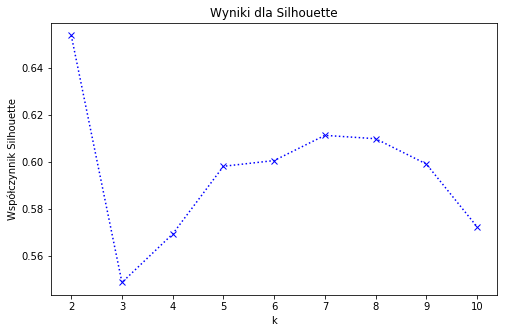

In [20]:
import matplotlib.pyplot as plt
cluster_num_seq = range(2, 11)

plt.figure(figsize = (8, 5))
plt.plot(cluster_num_seq, agg_scores(data, 10)[0], 'bx:')
plt.xlabel('k')
plt.ylabel('Współczynnik Silhouette')
plt.title('Wyniki dla Silhouette')
plt.show()      

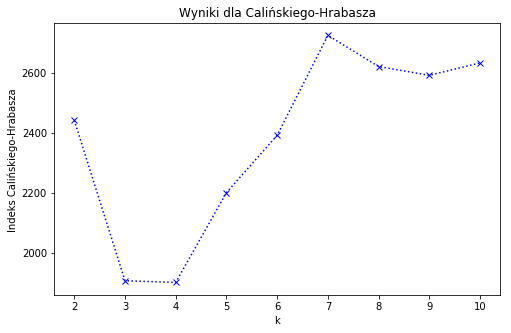

In [5]:
import matplotlib.pyplot as plt
cluster_num_seq = range(2, 11)

plt.figure(figsize = (8, 5))
plt.plot(cluster_num_seq, agg_scores(data, 10)[1], 'bx:')
plt.xlabel('k')
plt.ylabel('Indeks Calińskiego-Hrabasza ')
plt.title('Wyniki dla Calińskiego-Hrabasza')
plt.show()  

Współczynnik Silhouette jasno wskazuje, że najlepsze wyniki osiągniemy przy k=2. W przypadku Indeksu Calińskiego-Hrabasza optymalny jest wybór maksimum lokalnego o najmniejszej liczbie klastrów, czyli również dla k=2. Warto zauważyć, że obie miary są zgodne również co do wyboru drugiej najlepszej liczby klastrów. W obu przypadkach jest to k=7.

### Wizualizacja przypisania do klastrów

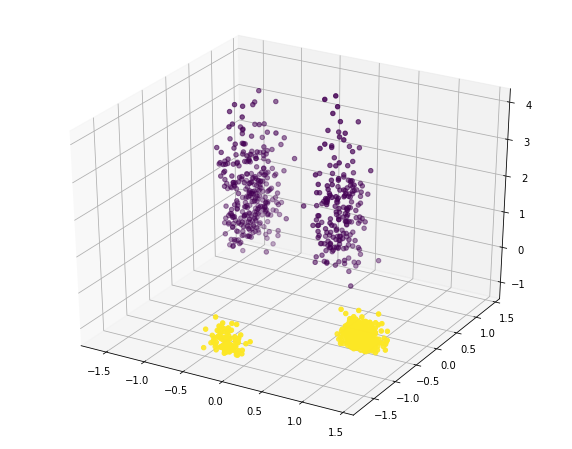

In [6]:
model = AgglomerativeClustering(n_clusters=2)
labels = model.fit_predict(data)

xs = data.x1
ys = data.x2
zs = data.x3


# Rysujemy 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1, projection = '3d')
ax.scatter(ys, xs, zs, c = labels)


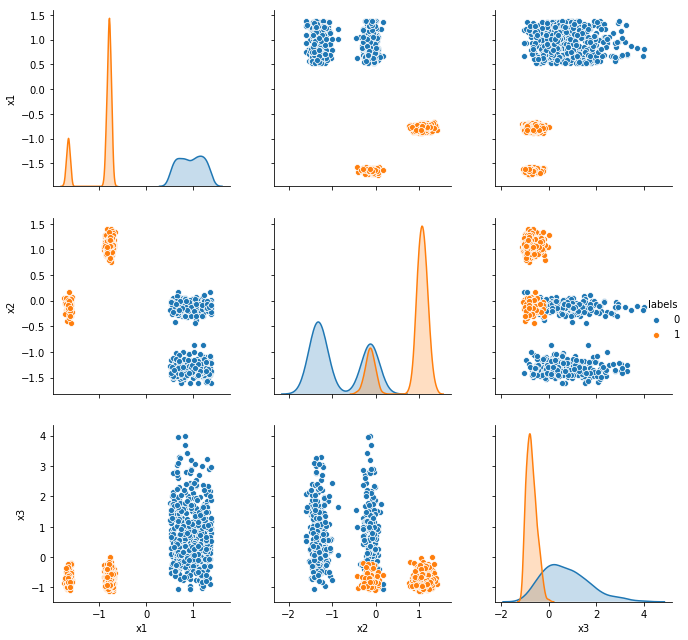

In [7]:
import seaborn as sns
import copy

data_vis = copy.deepcopy(data)
data_vis['labels'] = labels

sns.pairplot(data_vis, height=3, hue='labels', vars=["x1", "x2", "x3"])
plt.tight_layout()

### Opis wyników

Podział zbioru na dwie części wygląda na prawidłowy. Ewentualnie, bardziej naturalny mógłby być podział na 4 podzbiory.

## 2. DBSCAN

Algorytm DBSCAN sam dobiera optymalną liczbę klastrów, jednak musimy dobrać maksymalny dystans pomiędzy dwoma punktami określanymi jako sąsiednie (epsilon). Do tego celu użyłem tych samych metryk co przy algorytmie aglomeracyjnym.

### Wybór Epsilonu

In [8]:
from sklearn.cluster import DBSCAN

# Miara Silhouette + Caliński-Harabasz

def dbscan_scores(X, epsilon_list):
    s_scores = [] 
    c_scores = []
    
    for k in epsilon_list:
        model = DBSCAN(eps = k, min_samples = 5)
        labels = model.fit_predict(X)
        # Silhouette
        silhouette = silhouette_score(X, labels)
        s_scores.append(silhouette)
        # Caliński-Harabasz
        calinski = calinski_harabasz_score(X, labels)
        c_scores.append(calinski)
        
        
    return s_scores, c_scores 



[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


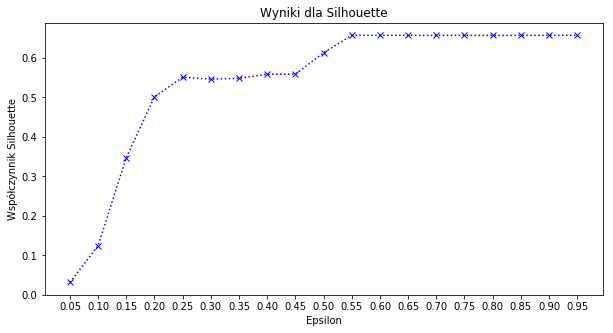

In [9]:
eps_list = np.arange(0.05, 1, 0.05)

# Badamy epsilon z przedziału 0.05 - 0.95 z krokiem co 0.05
print(eps_list)

plt.figure(figsize = (10, 5))
plt.plot(eps_list, dbscan_scores(data, eps_list)[0], 'bx:')
plt.xlabel('Epsilon')
plt.xticks(ticks=eps_list)
plt.ylabel('Współczynnik Silhouette')
plt.title('Wyniki dla Silhouette')
plt.show()    

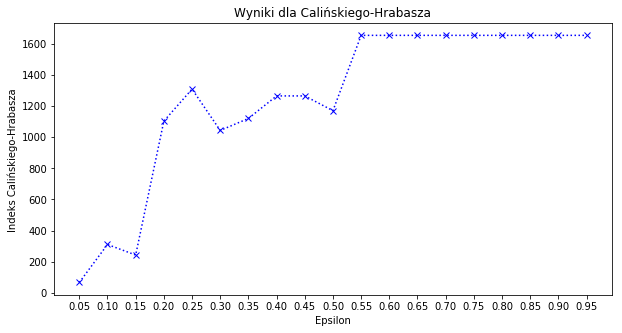

In [10]:
plt.figure(figsize = (10, 5))
plt.plot(eps_list, dbscan_scores(data, eps_list)[1], 'bx:')
plt.xlabel('Epsilon')
plt.xticks(ticks=eps_list)
plt.ylabel('Indeks Calińskiego-Hrabasza ')
plt.title('Wyniki dla Calińskiego-Hrabasza')
plt.show()    

Wyniki dla obu miar są bardzo podobne, najlepszy wyniki algorytm osiąga dla epsilon <= 0.55. Przyjmijmy więc taką wartość.

### Wizualizacja przypisania do klastrów

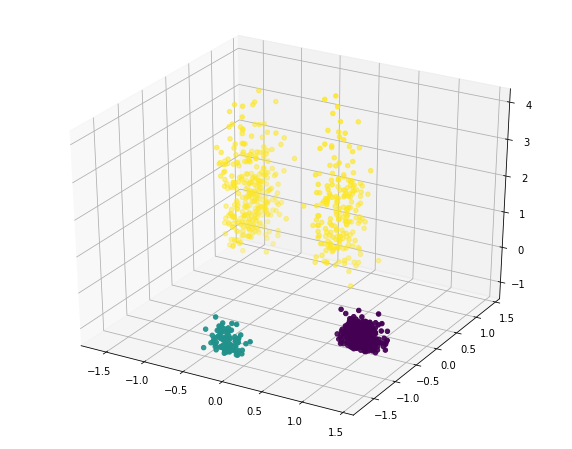

In [11]:
model = DBSCAN(eps = 0.55)
labels = model.fit_predict(data)

xs = data.x1
ys = data.x2
zs = data.x3


# Rysujemy 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1, projection = '3d')
ax.scatter(ys, xs, zs, c = labels)


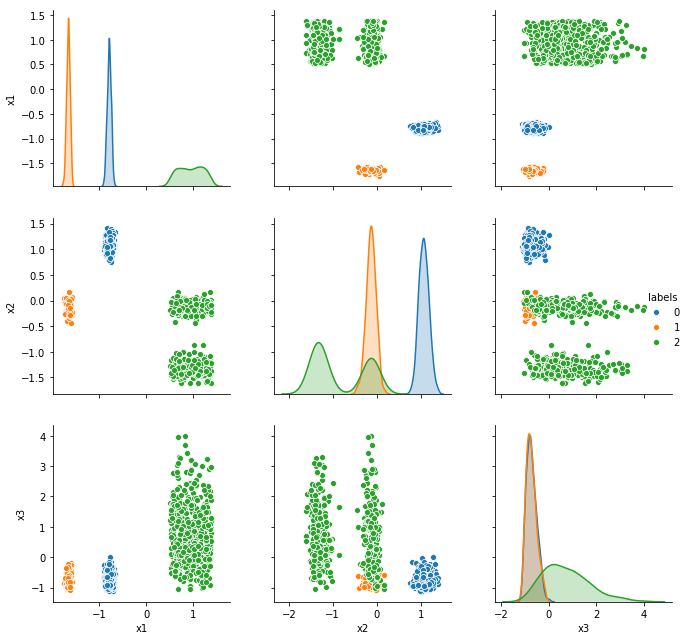

In [12]:
data_vis = copy.deepcopy(data)
data_vis['labels'] = labels

sns.pairplot(data_vis, height=3, hue='labels', vars=["x1", "x2", "x3"])
plt.tight_layout()

### Opis wyników

DBSCAN podzielił zbiór na 3 klastry. Jest to również sensowny podział, nie ma punktów, które zostałyby ewidentie źle dopasowane. 

## 3. Opis Metryk i wyników

Współczynnik Silhouette <- Uśredniony po wszystkich punktach współczynnik tego jak dobrze dany punkt pasuje do danego klastra, w porównaniu z drugim najlepszym wyborem. Premiowane są okrągłe podzbiory. 

Indeks Calińskiego - Harabasza <- Indeks postaci:
\begin{equation*}
VRC = \frac{BGSS}{k-1} /
\frac{WGSS}{n-k}
\end{equation*}

gdzie WGSS to suma odległości punktów od środka skupienia, BGSS to suma odległości centroidów od siebie, k to liczba klastrów, a n to liczba punktów. Czyli im centroidy są bardziej od siebie oddalone lub punkty są bliżej centrów skupienia, tym wynik jest wyższy.

In [19]:
model_1 = AgglomerativeClustering(n_clusters=2)
labels_1 = model_1.fit_predict(data)

model_2 = DBSCAN(eps = 0.55)
labels_2 = model_2.fit_predict(data)



calinski_1 = calinski_harabasz_score(data, labels_1)
silhouette_1 = silhouette_score(data, labels_1)
print('Wyniki dla Agglomerative:')
print('Silhouette -> ',  silhouette_1)
print("Caliński -> ", calinski_1)
print('')

calinski_2 = calinski_harabasz_score(data, labels_2)
silhouette_2 = silhouette_score(data, labels_2)
print('Wyniki dla DBSCAN:')
print('Silhouette -> ',  silhouette_2)
print("Caliński -> ", calinski_2)


Wyniki dla Agglomerative:
Silhouette ->  0.6537699610357462
Caliński ->  2442.3158768493413

Wyniki dla DBSCAN:
Silhouette ->  0.6571745269702408
Caliński ->  1654.5112565022116


Miara Silhouette osiąga podobny poziom dla obu algorytmów. Duża różnica występuje natomiast w przypadku indeksu Calińskiego - Harabasza. Dla algorytmu aglomeracyjnego, jest on znacznie wyższy. Wiąże się to z większą liczbą klastrów w DBSCAN, co powoduje zmniejszenie odległości pomiędzy ich środkami i w konsekwencji także wartości tej miary, pomimo zmniejszonego WGSS. Po weryfikacji wizualnej widać jednak, iż oba algorytmy zadziałały sensownie. Jeśli miałbym dokonać wyboru jedynie na podstawie miar, to oczywiście wybrałbym algorytm aglomeracyjny.

## Oświadczenie

Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu Wstęp do Uczenia Maszynowego została wykonana przeze mnie samodzielnie.

Piotr Sieńko 